# Unique species
Visualize the numbers of unique species within and across kingdoms.

In [1]:
import json
from collections import defaultdict
import sys
sys.path.append('../desiccation_network/build_citation_network/')
from classify_papers import map_specs_to_kings
import taxoniq
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

2024-02-13 12:48:25.032531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 12:48:27.534569: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Read in & preprocess data

In [2]:
graph = nx.read_graphml('../data/citation_network/core_collection_destol_or_anhydro_FILTERED_classified_network_06Jan2023_MANUALLY_VERIFIED.graphml')

In [3]:
with open('../data/citation_network/intermediate_saves/classmains_07Jan2024/species_ids.json') as myf:
    species_ids = json.load(myf)

In [4]:
# Cast all NCBI Taxonomy IDs to integers
species_ids = {k: int(v) for k, v in species_ids.items()}

## Numbers of unique species
### Entire dataset

In [5]:
total_uniq = set(species_ids.values())
print(f'There are {len(total_uniq)} unique species mentions in the overall dataset before processing to kingdoms.')

There are 4809 unique species mentions in the overall dataset before processing to kingdoms.


### Per class

In [6]:
full_species_dict = map_specs_to_kings(species_ids)

100%|██████████| 7297/7297 [00:01<00:00, 6336.77it/s]

When building the species --> kingdom dict, 201 species were dropped because their kingdom wasn't in our list of interest, 4 were dropped because they were only identifyable as Eukaryota, and 15 because they did not appear in taxoniq's local version of NCBI Taxonomy. This could mean they are not in the actual taxonomy, or that they were added after taxoniq last updated its database version. Finally, 1 species were dropped because their lineage in the taxonomy entry was empty.


We want to disambiguate repeated species, we can do that by using their IDs:

In [7]:
unique_spec_kings = defaultdict(list)
for spec, king in full_species_dict.items():
    taxon_id = species_ids[spec]
    unique_spec_kings[king].append(taxon_id)
unique_spec_kings = {k: list(set(v)) for k, v in unique_spec_kings.items()}

In [8]:
for king, specs in unique_spec_kings.items():
    print(f'There are {len(specs)} unique database-normalized species in kingdom {king}.')

There are 2095 unique database-normalized species in kingdom Plant.
There are 1652 unique database-normalized species in kingdom Animal.
There are 542 unique database-normalized species in kingdom Microbe.
There are 293 unique database-normalized species in kingdom Fungi.


In [9]:
print(f'There are {sum([len(v) for v in unique_spec_kings.values()])} total unique species across our kingdoms of interest.')

There are 4582 total unique species across our kingdoms of interest.


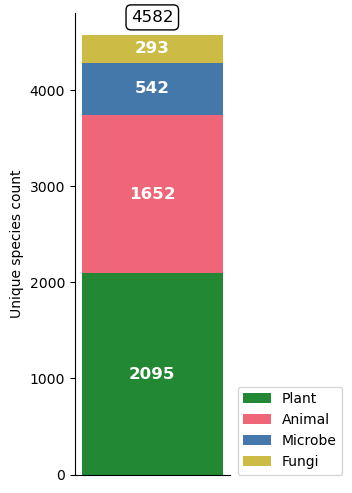

In [10]:
colors = {'Plant': '#228833', 'Animal':'#EE6677', 'Microbe': '#4477AA', 'Fungi':'#CCBB44'}
bottom = np.zeros(1)
fig, ax = plt.subplots(figsize=(2,6))
for king, specs in unique_spec_kings.items():
    count = len(specs)
    ax.bar('Dataset', count, color=colors[king], label=king, bottom=bottom)
    bottom += count
    
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        0.5*bar.get_height() + bar.get_y(),
        int(bar.get_height()),
        ha='center',
        va='center',
        color='w',
        weight='bold',
        size=12
    )
    
    centered_x = bar.get_x() + bar.get_width() / 2
    top_y = bar.get_height() + bar.get_y()

ax.text(centered_x, top_y + 100, sum([len(v) for v in unique_spec_kings.values()]), bbox={'boxstyle':'round', 'facecolor':'w'}, ha='center', va='bottom', fontsize=12)
ax.set_ylabel('Unique species count')
ax.spines[['right', 'top']].set_visible(False)
ax.get_xaxis().set_visible(False)
plt.legend(loc=(1.05,0))
plt.savefig('../data/citation_network/figures/unique_species_per_kingdom_bar.png', format='png', dpi=600, bbox_inches='tight')

## Papers per kingdom
We want a similar plot, but for papers instead of species.

In [11]:
papers_per_king = defaultdict(int)
for node, attrs in graph.nodes(data=True):
    papers_per_king[attrs['study_system']] += 1

In [14]:
papers_per_king

defaultdict(int, {'Plant': 3627, 'Animal': 1176, 'Microbe': 620, 'Fungi': 141})

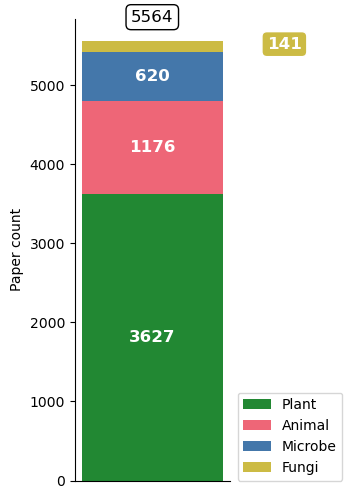

In [45]:
colors = {'Plant': '#228833', 'Animal':'#EE6677', 'Microbe': '#4477AA', 'Fungi':'#CCBB44'}
bottom = np.zeros(1)
fig, ax = plt.subplots(figsize=(2,6))
for king, pprs in papers_per_king.items():
    ax.bar('Dataset', pprs, color=colors[king], label=king, bottom=bottom)
    bottom += pprs
    
for bar in ax.patches:
    if int(bar.get_height()) == 141:
        fung_y =  bar.get_y()
        top_y = bar.get_height() + fung_y
        continue
    else:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            0.5*bar.get_height() + bar.get_y(),
            int(bar.get_height()),
            ha='center',
            va='center',
            color='w',
            weight='bold',
            size=12
        )
    
    centered_x = bar.get_x() + bar.get_width() / 2

obj = ax.text(0.75, fung_y, papers_per_king['Fungi'], bbox={'boxstyle':'round', 'facecolor':colors['Fungi'], 'edgecolor':'w'}, ha='center', va='bottom', fontsize=12, color='w', weight='bold')
# box = obj.get_bbox_patch()
# fig.canvas.draw()
# coords = ax.transData.inverted().transform(box.get_window_extent())
# x = coords[0][0]
# y = coords[1][1] - coords[0][1]
# ax.arrow(x, y, -0.25, 0)
ax.text(centered_x, top_y + 200, sum(papers_per_king.values()), bbox={'boxstyle':'round', 'facecolor':'w'}, ha='center', va='bottom', fontsize=12)
ax.set_ylabel('Paper count')
ax.spines[['right', 'top']].set_visible(False)
ax.get_xaxis().set_visible(False)
plt.legend(loc=(1.05,0))
plt.savefig('../data/citation_network/figures/papers_per_kingdom_bar.png', format='png', dpi=600, bbox_inches='tight')

## Papers versus species in each category

In [41]:
num_papers = defaultdict(int)
for node, attrs in graph.nodes(data=True):
    num_papers[attrs['study_system']] += 1

In [42]:
uniq_spec_nums = {k: len(v) for k, v in unique_spec_kings.items()}

In [43]:
uniq_spec_nums_normed = {k: v/sum(uniq_spec_nums.values()) for k, v in uniq_spec_nums.items()}
num_papers_normed = {k: v/sum(num_papers.values()) for k, v in num_papers.items()}

In [44]:
uniq_spec_nums_normed

{'Plant': 0.45722391968572673,
 'Animal': 0.3605412483631602,
 'Microbe': 0.11828895678742907,
 'Fungi': 0.06394587516368398}

In [45]:
num_papers_normed

{'Plant': 0.6518691588785047,
 'Animal': 0.2113587347232207,
 'Microbe': 0.11143062544931703,
 'Fungi': 0.025341480948957586}

In [46]:
bars_df = pd.DataFrame.from_dict(num_papers_normed, orient='index', columns=['Papers'])

In [47]:
bars_df = bars_df.merge(pd.DataFrame.from_dict(uniq_spec_nums_normed, orient='index', columns=['Species']), right_index=True, left_index=True)

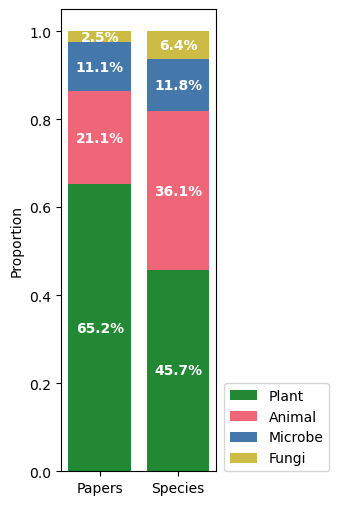

In [61]:
fig, ax = plt.subplots(figsize=(2,6))
bottom = np.zeros(bars_df.shape[1])

for system in bars_df.index:
    p = ax.bar(bars_df.columns.astype(str), bars_df.loc[system], color=colors[system], label=system, bottom=bottom)
    bottom += bars_df.loc[system]

for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        0.5*bar.get_height() + bar.get_y(),
        str(round(bar.get_height()*100, 1)) + '%',
        ha='center',
        va='center',
        color='w',
        weight='bold',
        size=10
    )
    
    centered_x = bar.get_x() + bar.get_width() / 2
    top_y = bar.get_height() + bar.get_y()

    
ax.set_ylabel('Proportion')
plt.legend(loc=(1.05,0))
plt.savefig('../data/citation_network/figures/papers_vs_species.png', format='png', dpi=600, bbox_inches='tight')